# OpenAI + QDrant

In [135]:
import os
from tqdm import tqdm
from utils import *
import logging
import pandas as pd
from datetime import datetime
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
# set up a logger with file of current time
logging.basicConfig(filename=f'../data/logs/{datetime.now().strftime("%Y-%m-%d_%H-%M-%S")}.log', level=logging.DEBUG)

In [3]:
# company = "reit"
company = "TSX_Y_2022"
# company = "NASDAQ_CLXT_2022"

test_pdf_path = f"../data/pdfs/{company}.pdf"

In [4]:
# Load questions
with open(f"../data/questions/clxt-tsxy.json", "r") as file:
    questions = json.load(file)

# open companies list
companies_dict = get_companies_dict(r"C:\Users\felix.krause\code\trustbit\enterprise-rag-challenge\dataset_v2.json")

In [5]:
# Load prompt
with open("prompts/prompt_openAI-qdrant.md", "r") as file:
    system_prompt = file.read()

print(system_prompt[:100])

## SYSTEM PROMPT

You are a chatbot designed to answer questions about company annual reports. The i


In [6]:
# only keep subset for dev
companies = ["Calyxt, Inc.", "Yellow Pages Limited"]
companies_dict = {company: data for company, data in companies_dict.items() if company in companies}

In [7]:
companies_dict

{'Calyxt, Inc.': {'id': 'NASDAQ_CLXT_2022.pdf',
  'sha1': '40b5cfe0d7bbf59e186492bfbe1b5002d44af332'},
 'Yellow Pages Limited': {'id': 'TSX_Y_2022.pdf',
  'sha1': '9d7a72445aba6860402c3acce75af02dc045f74d'}}

## Docling - Processing PDFs

In [131]:
companies_dict

{'Calyxt, Inc.': {'id': 'NASDAQ_CLXT_2022.pdf',
  'sha1': '40b5cfe0d7bbf59e186492bfbe1b5002d44af332'},
 'Yellow Pages Limited': {'id': 'TSX_Y_2022.pdf',
  'sha1': '9d7a72445aba6860402c3acce75af02dc045f74d'}}

In [137]:
# Potential for parallelization for files?
from docling.document_converter import DocumentConverter

converter = DocumentConverter()  # 20 sec for setting up

logs = {"failed": [], "skipped": []}
for company, data in tqdm(companies_dict.items()):
    pdf_path = f"../data/pdfs/{data['id']}"
    docling_md_path = f"../data/docling_md/docling_{data['id'][:-4]}.md"

    if not os.path.exists(docling_md_path):
        print(f"Processing {company}")
        try:
            result = converter.convert(pdf_path)
            with open(docling_md_path, "w", encoding="utf-8") as file:
                file.write(result.document.export_to_markdown())
        except Exception as e:
            print(f"Error processing {company}: {e}")
            logs["failed"].append({"company_id": company, "error": e})
    else:
        print(f"Skipping {company}")
        logs["skipped"].append(company)

if logs["failed"]:
    print(f"Nr of failed companies: {len(logs['failed'])}")

# RUNTIMES:
# REIT: execution for 7.4MB with 97 pages -> 5 min
# Yellow Pages: execution for 1.4MB with 77 pages -> 4 min
# Calyxt: execution for 0.7MB with 88 pages -> 3min

# NOTES:
# brackets in tables indicate negative values
# parsing issues (see current system prompt)

100%|██████████| 2/2 [00:00<?, ?it/s]

../data/docling_md/docling_NASDAQ_CLXT_2022.md
Skipping Calyxt, Inc.
../data/docling_md/docling_TSX_Y_2022.md
Skipping Yellow Pages Limited


In [22]:
# STORE as md with correct utf-8 encoding
# with open(f"../data/docling_md/dev/docling_{company}.md", "w", encoding="utf-8") as file:
#     file.write(result.document.export_to_markdown())

## Custom Advanced Chunking

In [8]:
import re

def is_table_paragraph(paragraph):
    """
    Returns True if the paragraph looks like a markdown table block.
    We assume that a table block consists of lines that begin with '|'
    and that at least one line is a separator (i.e. contains a series of dashes).
    """
    lines = paragraph.strip().splitlines()
    if not lines:
        return False
    if not all(line.lstrip().startswith('|') for line in lines):
        return False
    for line in lines:
        if re.search(r'\|\s*-{2,}', line):
            return True
    return False

def get_overlap_text(text, desired_overlap, max_overlap=None):
    """
    Extracts an overlap string from the end of `text` made up of whole words.

    Args:
        text (str): The text from which to extract the overlap.
        desired_overlap (int): Desired minimum number of characters to include in the overlap.
        max_overlap (int or None): Maximum allowed overlap (in characters). If None, no hard cap is applied.

    Returns:
        str: A string composed of whole words from the end of `text` whose total length
             is at least `desired_overlap` (if possible) but not exceeding `max_overlap` (if provided).
    """
    if max_overlap is None:
        max_overlap = desired_overlap * 2

    words = text.split()
    if not words:
        return ""

    overlap_words = []
    total_length = 0
    # Iterate over the words in reverse order.
    for word in reversed(words):
        # Add a space before each word except the first one we add.
        addition_length = len(word) if not overlap_words else len(word) + 1
        # If a maximum overlap is set and adding this word would exceed it,
        # then stop (unless no word has been added yet).
        if max_overlap is not None and total_length + addition_length > max_overlap:
            if overlap_words:
                break
            # Else, if even a single word is longer than max_overlap, add its characters until max is reached.
            if len(word) > max_overlap:
                overlap_words.append(word[:max_overlap - total_length])
                break
        overlap_words.append(word)
        total_length += addition_length
        # Stop if we've reached at least the desired overlap.
        if total_length >= desired_overlap:
            break

    # Reassemble the words in the correct order.
    return " ".join(reversed(overlap_words))

def split_paragraph(paragraph, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Splits a non-table paragraph (by words) so that each part is below max_chars.
    If the paragraph is split into multiple parts, each subsequent part will begin with an
    overlap taken from the tail of the previous part. The overlap is composed of whole words,
    trying to reach at least `overlap_chars` characters but never exceeding `max_overlap_chars` (if set).

    Args:
        paragraph (str): The paragraph text to split.
        max_chars (int): Maximum allowed character length per part.
        overlap_chars (int): Desired number of characters to overlap between parts.
        max_overlap_chars (int or None): Absolute maximum allowed overlap (in characters).

    Returns:
        list of str: A list of paragraph parts, each no longer than max_chars.
    """
    words = paragraph.split()
    parts = []
    current = ""

    for word in words:
        candidate = (current + " " + word).strip() if current else word
        if len(candidate) > max_chars:
            # If we have accumulated some text, finalize it.
            if current:
                parts.append(current)
                # Compute an overlap from the end of current, as whole words.
                overlap_text = get_overlap_text(current, overlap_chars, max_overlap_chars) if overlap_chars > 0 else ""
                # Try to start the next segment with the overlap plus the current word.
                new_candidate = (overlap_text + " " + word).strip() if overlap_text else word
                if overlap_text and len(new_candidate) <= max_chars:
                    current = new_candidate
                else:
                    current = word
            else:
                # In the unlikely case a single word exceeds max_chars, yield it as its own part.
                parts.append(word)
                current = ""
        else:
            current = candidate
    if current:
        parts.append(current)
    return parts

def split_content(text, max_chars, overlap_chars=0, max_overlap_chars=None):
    """
    Split a block of text into parts no longer than max_chars.
    The text is first split into paragraphs (using double newlines) so that
    tables and other contiguous blocks remain intact. If an individual paragraph
    is too long and is not a table, it is further split with an overlap between parts.
    Also, for each final part a flag is computed (True/False) indicating whether the part is a table.

    Returns:
        tuple:
            - parts (list of str): The split parts.
            - is_table_ls (list of bool): For each part, True if it is a table block, False otherwise.
    """
    paragraphs = text.split("\n\n")
    parts = []
    is_table_ls = []  # This will store a True/False flag per part.

    current_part = ""
    current_part_is_table = None  # Will be set to True for table parts, False for non-table.

    for para in paragraphs:
        para = para.strip()
        if not para:
            continue

        para_is_table = is_table_paragraph(para)
        # If this paragraph is a table, do not merge with other content.
        if para_is_table:
            # TODO also include overlap to table!
            # TODO if table is larger then embedding model allows, split into smaller tables - how often does it happen?
            if current_part:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = None
            parts.append(para)
            is_table_ls.append(True)
            continue

        # For non-table paragraphs, if too long, split further.
        if len(para) > max_chars:
            sub_parts = split_paragraph(para, max_chars, overlap_chars, max_overlap_chars)
        else:
            sub_parts = [para]

        for sub in sub_parts:
            # If current_part is non-empty but from a different type (table vs. non-table), flush it.
            if current_part and current_part_is_table is not False:
                parts.append(current_part)
                is_table_ls.append(current_part_is_table)
                current_part = ""
                current_part_is_table = False

            candidate = (current_part + "\n\n" + sub).strip() if current_part else sub
            if len(candidate) <= max_chars:
                current_part = candidate
                current_part_is_table = False  # Non-table content.
            else:
                if current_part:
                    parts.append(current_part)
                    is_table_ls.append(current_part_is_table)
                current_part = sub
                current_part_is_table = False

    if current_part:
        parts.append(current_part)
        is_table_ls.append(current_part_is_table)

    return parts, is_table_ls

def chunk_markdown(markdown_text, document_name, context_window=2, max_chunk_size=2000, overlap_chars=500, max_overlap_chars=None):
    """
    Splits a markdown document into chunks based on headings and attaches metadata,
    including previous context_window section titles. If a section's content is too large,
    it is further split into sub‐chunks with an optional overlap (in characters) between
    consecutive parts.

    Args:
        markdown_text (str): The markdown document.
        context_window (int): Number of previous headings to include as context.
        max_chunk_size (int): Maximum allowed character length per (sub-)chunk.
        overlap_chars (int): Desired number of characters to overlap when splitting paragraphs (considering words).
        max_overlap_chars (int): Maximum allowed overlap between consecutive parts.

    Returns:
        list of dict: Each dict represents a (sub-)chunk and contains:
            - 'title': Heading text.
            - 'level': Heading level (number of '#' characters).
            - 'content': Content of the (sub-)chunk.
            - 'previous_titles': List of previous section titles.
            - 'part_index': Index of this part (1-based).
            - 'total_parts': Total number of parts for this section.
    """
    heading_pattern = re.compile(r'^(#{1,6})\s+(.*)$', re.MULTILINE)
    matches = list(heading_pattern.finditer(markdown_text))

    chunks = []

    # If no headings are found, treat the whole document as one chunk.
    if not matches:
        content_parts, is_table_ls = split_content(markdown_text.strip(), max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls)
        total_parts = len(content_parts)
        for i, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunks.append({
                'title': None,
                'level': None,
                'table': is_table,
                'content': part,
                'previous_titles': [],
                'part_index': i,
                'total_parts': total_parts
                # TODO also include page number of chunk here
            })
        return chunks

    # Process each section defined by a heading.
    for i, match in enumerate(matches):
        heading_marker = match.group(1)
        title = match.group(2).strip()
        level = len(heading_marker)

        # Determine content boundaries.
        content_start = match.end()
        content_end = matches[i+1].start() if i+1 < len(matches) else len(markdown_text)
        content = markdown_text[content_start:content_end].strip()

        previous_titles = [m.group(0).strip() for m in matches[max(0, i-context_window):i]]
        next_titles = [m.group(0).strip() for m in matches[i+1:i+context_window+1]]

        # Split the section's content if it's too large.
        content_parts, is_table_ls = split_content(content, max_chunk_size, overlap_chars, max_overlap_chars)
        assert len(content_parts) == len(is_table_ls), f"Lengths: {len(content_parts)} vs {len(is_table_ls)}"
        total_parts = len(content_parts)
        for j, (part, is_table) in enumerate(zip(content_parts, is_table_ls), start=1):
            chunk = {
                'title': title,
                'level': level,
                'previous_titles': previous_titles,
                'next_titles': next_titles,
                'company': document_name,
                'table': is_table,
                'part_index': j,
                'total_parts': total_parts,
                'content': part,
            }
            chunks.append(chunk)
    return chunks

def pretty_print_chunks(chunks):
    for chunk in chunks:
        print("Title:", chunk['title'])
        print("Company:", chunk['company'])
        print("Level:", chunk['level'])
        print("Is Table:", chunk['table'])
        print("Part: {}/{}".format(chunk['part_index'], chunk['total_parts']))
        print("Previous Titles:", chunk['previous_titles'])
        print("Next Titles:", chunk['next_titles'])
        print("Content:\n", chunk['content'])
        print("-" * 40)

# --- Example usage ---
sample_markdown = """
# Annual Report 2024

Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et augue. Sed sodales, purus eget vulputate mollis, enim ipsum convallis magna, eget interdum urna arcu sit amet libero.

## Financial Overview

| For the years ended December 31,                                                                  | 2022         | 2021         |
|---------------------------------------------------------------------------------------------------|--------------|--------------|
| Cash flows from operating activities                                                              |              |              |
| Change in operating assets and liabilities                                                        | $  4,728     | $  26,154    |
| Stock-based compensation cash payments                                                            | (7,155)      | (5,541)      |
| Funding of post-employment benefit plans in excess of costs                                       | (32,106)     | (7,523)      |
| Income taxes paid, net                                                                            | (7,758)      | -            |
| Cash flows from operations, excluding the above                                                   | 91,791       | 91,489       |
|                                                                                                   | $  49,500    | $  104,579   |
| Cash flows used in investing activities                                                           |              |              |
| Additions to intangible assets                                                                    | $  (4,911)   | $  (4,957)   |
| Additions to property and equipment                                                               | (93)         | (117)        |
| Payments received from net investment in subleases                                                | 1,338        | 593          |
|                                                                                                   | $  (3,666)   | $  (4,481)   |
| Cash flows used in financing activities                                                           |              |              |
| Repayment of exchangeable debentures                                                              | $  -         | $  (107,033) |
| Repurchase of common shares through NCIBs                                                         | (12,404)     | (5,334)      |
| Repurchase of common shares per plan of arrangement, net of treasury shares and transaction costs | (96,125)     | -            |
| Issuance of common shares                                                                         | 153          | 111          |
| Payment of lease obligations                                                                      | (2,947)      | (3,045)      |
| Dividends paid                                                                                    | (14,163)     | (14,730)     |
|                                                                                                   | $  (125,486) | $  (130,031) |
| NET DECREASE IN CASH                                                                              | $  (79,652)  | $  (29,933)  |
| CASH, BEGINNING OF YEAR                                                                           | 123,559      | 153,492      |
| CASH, END OF YEAR                                                                                 | $  43,907    | $  123,559   |

Additional commentary follows the table to elaborate on the financial performance. More descriptive text is added to simulate a very large chunk that should be split intelligently. Lorem ipsum dolor sit amet, consectetur adipiscing elit. Praesent ac nibh vestibulum, imperdiet orci sit amet, dictum urna.
"""

# For demonstration, set a lower max_chunk_size (e.g. 500 characters) and an overlap of 50 characters.
chunks = chunk_markdown(sample_markdown, company, context_window=3, max_chunk_size=200, overlap_chars=50, max_overlap_chars=100)

pretty_print_chunks(chunks)

# TODO also include overlap to table!
# TODO merge with next section if a chunk is too small

Title: Annual Report 2024
Company: TSX_Y_2022
Level: 1
Is Table: False
Part: 1/3
Previous Titles: []
Next Titles: ['## Financial Overview']
Content:
 Introductory text for the report. This section contains some long descriptive text that might be very large and thus needs to be split into parts. Lorem ipsum dolor sit amet, consectetur adipiscing
----------------------------------------
Title: Annual Report 2024
Company: TSX_Y_2022
Level: 1
Is Table: False
Part: 2/3
Previous Titles: []
Next Titles: ['## Financial Overview']
Content:
 Lorem ipsum dolor sit amet, consectetur adipiscing elit. Vestibulum vel dolor eget velit efficitur aliquet. Donec ullamcorper, metus ac convallis facilisis, lorem urna commodo nunc, nec facilisis
----------------------------------------
Title: Annual Report 2024
Company: TSX_Y_2022
Level: 1
Is Table: False
Part: 3/3
Previous Titles: []
Next Titles: ['## Financial Overview']
Content:
 convallis facilisis, lorem urna commodo nunc, nec facilisis velit leo et a

In [9]:
# Chunking example
company_test = "NASDAQ_CLXT_2022"

with open(f"../data/docling_md/dev/docling_{company_test}.md", "r", encoding="utf-8") as file:
    text = file.read()

sample = text[:10000]

chunks = chunk_markdown(sample, company, context_window=3, max_chunk_size=2000, overlap_chars=500)

pretty_print_chunks(chunks[:10])

Title: UNITED STATES SECURITIES AND EXCHANGE COMMISSION
Company: TSX_Y_2022
Level: 2
Is Table: False
Part: 1/1
Previous Titles: []
Next Titles: ['## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE']
Content:
 Washington, D.C. 20549
----------------------------------------
Title: FORM 10-K
Company: TSX_Y_2022
Level: 2
Is Table: False
Part: 1/1
Previous Titles: ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION']
Next Titles: ['## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE', '## Table of Contents']
Content:
 <!-- image -->

(Mark One)

☒

ANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF

1934

For the fiscal year ended December 31, 2022;

or

☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934

For the transition period from                       to

Commission file number 001-38161
----------------------------------------
Title: Calyxt, Inc.
Company: TSX_Y_2022
Level: 2
Is Table: 

In [9]:
len(chunks)

389

## Create embeddings

In [11]:
# OPENAI EMBEDDINGS
from openai import OpenAI

embedding_client = OpenAI()

# Max input: 8191 tokens

# embedding_model = "text-embedding-3-large"
# embedding_size = 3072

embedding_model = "text-embedding-3-small"
embedding_size = 1536

In [ ]:
# Create embeddings for single sample
contents = [f"{chunk['title']}: {chunk['content']}" for chunk in chunks]
contents_cleaned = [txt.replace("\n", " ") for txt in contents]
embeddings = embedding_client.embeddings.create(input=contents_cleaned, model=embedding_model).data

embeddings = [emb.embedding for emb in embeddings]

# attach to chunks
db_data = []
for idx, chunk in enumerate(chunks):
    db_data.append({
        "embedding": embeddings[idx],
        "metadata": chunk,
    })

chunk.keys()

In [12]:
# EMBED IN BULK
from openai import OpenAI
embedding_client = OpenAI()

db_data = []
failed_companies = []
for company, data in tqdm(companies_dict.items()):
    try:
        company_id = data["id"][:-4]

        with open(f"../data/docling_md/docling_{company_id}.md", "r", encoding="utf-8") as file:
            text = file.read()

        chunks = chunk_markdown(text, company, context_window=4, max_chunk_size=3000, overlap_chars=500)

        contents = [f"{chunk['title']}: {chunk['content']}" for chunk in chunks]
        contents_cleaned = [txt.replace("\n", " ") for txt in contents]
        embeddings = embedding_client.embeddings.create(input=contents_cleaned, model=embedding_model).data

        embeddings_collected = [emb.embedding for emb in embeddings]

        for idx, chunk in enumerate(chunks):
            db_data.append({
                "embedding": embeddings_collected[idx],
                "metadata": chunk,
            })
    except Exception as e:
        print(f"Error processing {company}: {e}")
        failed_companies.append(company)

if failed_companies:
    print(f"WARNING: Nr of failed companies: {len(failed_companies)}")

100%|██████████| 2/2 [00:06<00:00,  3.39s/it]


In [155]:
# # LOCAL APPROACH
# from sentence_transformers import SentenceTransformer
#
# # Initialize the pre-trained model
# embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
# embedding_size = 384
#
# # TODO make this more sophisticated, to include metadata in embedding
# contents = [f"{chunk['title']} - {chunk['content']}" for chunk in chunks]
# contents_cleaned = [txt.replace("\n", " ") for txt in contents]
#
# # Generate the embedding
# embeddings = embedding_model.encode(contents_cleaned)
# embeddings = [emb.tolist() for emb in embeddings]

In [13]:
db_data[1]["metadata"]

{'title': 'FORM 10-K',
 'level': 2,
 'previous_titles': ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION'],
 'next_titles': ['## Calyxt, Inc.',
  '## DOCUMENTS INCORPORATED BY REFERENCE',
  '## Table of Contents',
  '## Table of Contents'],
 'company': 'Calyxt, Inc.',
 'table': False,
 'part_index': 1,
 'total_parts': 1,
 'content': '<!-- image -->\n\n(Mark One)\n\n☒\n\nANNUAL REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF\n\n1934\n\nFor the fiscal year ended December 31, 2022;\n\nor\n\n☐ TRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\n\nFor the transition period from                       to\n\nCommission file number 001-38161'}

## Creating vector database

In [19]:
# Specify collection name
collection_name = "rag_test_db"

In [14]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/
# Local quickstart: https://qdrant.tech/documentation/quickstart/
from qdrant_client import models, QdrantClient

# Connect to Qdrant
db_client = QdrantClient(":memory:")

# first start qdrant server
# set up: docker pull qdrant/qdrant
# docker run -p 6333:6333 -p 6334:6334 -v "$(pwd)/data/qdrant_storage:/qdrant/storage:z" qdrant/qdrant
# db_client = QdrantClient(url="http://localhost:6333")

# Define collection parameters
# embedding_size = 384

if not db_client.collection_exists(collection_name):
    db_client.create_collection(
        collection_name=collection_name,
        vectors_config=models.VectorParams(
                size=embedding_size,
                distance=models.Distance.COSINE  # or Distance.EUCLID, etc.
            )
    )

db_client.upload_points(
    collection_name=collection_name,
    points=[
        models.PointStruct(id=idx, vector=data["embedding"], payload=data["metadata"])
        for idx, data in enumerate(db_data)
    ],
)

## Retrieving from vector DB

In [15]:
# https://qdrant.tech/documentation/beginner-tutorials/search-beginners/
def retriever(query, company_name, collection_name, embedding_client, db_client, k=3):
    # query_embedding = embedding_model.encode(query).tolist()
    query_embedding = embedding_client.embeddings.create(input=query, model=embedding_model).data[0].embedding
    hits = db_client.query_points(
        collection_name=collection_name,
        query=query_embedding,
        # https://qdrant.tech/documentation/concepts/filtering/
        query_filter=models.Filter(must=[models.FieldCondition(key="company", match=models.MatchValue(value=company_name))]),
        limit=k  # number of top results
    ).points

    return hits

In [16]:
# demo_query = "For which year is the report?"
query_demo = "What is chapter 3 about?"

hits = retriever(query_demo, "Calyxt, Inc.", collection_name, embedding_client, db_client, k=3)

for hit in hits:
    print(hit.payload, "score:", hit.score)

{'title': 'Table of Contents', 'level': 2, 'previous_titles': ['## UNITED STATES SECURITIES AND EXCHANGE COMMISSION', '## FORM 10-K', '## Calyxt, Inc.', '## DOCUMENTS INCORPORATED BY REFERENCE'], 'next_titles': ['## Table of Contents', '## Terms', '## Cautionary Note Regarding Forward-Looking Statements', '## Table of Contents'], 'company': 'Calyxt, Inc.', 'table': False, 'part_index': 1, 'total_parts': 2, 'content': '3\n\n3\n\nTable of Contents'} score: 0.4286830423183803
{'title': '(a)(3) Exhibits', 'level': 2, 'previous_titles': ['## Item 11. Executive Compensation', '## Item 12. Security Ownership of Certain Beneficial Owners and Management and Related Stockholder Matters', '## Item 13. Certain Relationships and Related Transactions, and Director Independence', '## Item 14. Principal Accounting Fees and Services'], 'next_titles': ['## Table of Contents', '## Item 16. Form 10-K Summary', '## SIGNATURES', '## CALYXT, INC.'], 'company': 'Calyxt, Inc.', 'table': False, 'part_index': 3,

## LLM that thing!

In [18]:
import phoenix as px
from phoenix.otel import register

# pip install -q openinference-instrumentation-openai
from openinference.instrumentation.openai import OpenAIInstrumentor

px.launch_app()

tracer_provider = register(
    project_name="rag_openAI-qdrant",  # Default is 'default'
    endpoint="http://localhost:4317",  # Sends traces using gRPC
)

OpenAIInstrumentor().instrument(tracer_provider=tracer_provider)

🌍 To view the Phoenix app in your browser, visit http://localhost:6006/
📖 For more information on how to use Phoenix, check out https://docs.arize.com/phoenix
OpenTelemetry Tracing Details
|  Phoenix Project: rag_openAI-qdrant
|  Span Processor: SimpleSpanProcessor
|  Collector Endpoint: localhost:4317
|  Transport: gRPC
|  Transport Headers: {'user-agent': '****'}
|  
|  Using a default SpanProcessor. `add_span_processor` will overwrite this default.
|  
|  `register` has set this TracerProvider as the global OpenTelemetry default.
|  To disable this behavior, call `register` with `set_global_tracer_provider=False`.



In [109]:
# Identify company name
with open(f"prompts/prompt_company_extractor.md", "r") as file:
    prompt_company_extractor = file.read()

class Company(BaseModel):
    chain_of_thought: str = Field(..., description="Chain of thought that led to the answer value")
    value: str = Field(..., description="Identified company name as in list of companies.")

llm_company_name = OpenAI()

def get_company_name(query, companies_dict, verbose=True):
    companies = list(companies_dict.keys())
    company_name = None
    company_meta = None

    # Check if query contains company name directly
    candidates = []
    for company in companies:
        # Build a regex pattern that ignores case
        pattern = re.escape(company)
        if re.search(pattern, query, re.IGNORECASE):
            candidates.append(company)

    if len(candidates) == 1:
        if verbose:
            print(f"Found company name with re: {candidates[0]}")
        company_name = candidates[0]
        company_meta = companies_dict[candidates[0]]

    # If no company name was found, ask model to extract it
    if not company_meta:
        prompt = prompt_company_extractor.replace("<<COMPANIES>>", ", ".join(companies))

        completion = llm_company_name.beta.chat.completions.parse(
            # model="gpt-4o-2024-08-06",
            model="gpt-4o-mini",
            messages=[
                {"role": "system", "content": prompt},
                {"role": "user", "content": query},
            ],
            response_format=Company,
            temperature=0
        )

        if verbose:
            print(completion)

        company_name = completion.choices[0].message.parsed.value

        if company_name.lower() == "skip":
            return "N/A", None, None
        else:
            company_meta = companies_dict[company_name]

    return company_name, company_meta["id"], company_meta["sha1"]

In [52]:
completion = get_company_name("Did Calyxt, Inc. mention any mergers or acquisitions in the annual report", companies_dict)
print("OUTPUT:", completion)

Found company name with re: Calyxt, Inc.
{'id': 'NASDAQ_CLXT_2022.pdf', 'sha1': '40b5cfe0d7bbf59e186492bfbe1b5002d44af332'}
OUTPUT: ('Calyxt, Inc.', 'NASDAQ_CLXT_2022.pdf', '40b5cfe0d7bbf59e186492bfbe1b5002d44af332')


In [97]:
from pydantic import BaseModel
from openai import OpenAI
from pydantic import Field
from typing import List


llm = OpenAI()
collection_name = "rag_test_db"  # TODO

class AnswerLLM(BaseModel):
    chain_of_thought: str = Field(..., description="Chain of thought that led to the answer value")
    value: List[str] = Field(..., description="Answer to the question, according to the question kind")
    references: List[int] = Field(..., description="IDs of the chunks where evidence for the answer was found")  # TODO catch this, then use reverse search in PDF to identify page number


def ask_openai(user_query: str, kind: str, company_name: str, system_prompt: str, embedding_client, db_client, nr_rag_retrieval=5, verbose=True):

    hits = retriever(user_query, company_name, collection_name, embedding_client, db_client, k=nr_rag_retrieval)
    hits_str = "".join([f"chunk id: {response.id}, score: {response.score}, content: {response.payload}\n\n" for response in hits])

    system_prompt_full = system_prompt.replace("<<CONTEXT>>", hits_str)

    completion = llm.beta.chat.completions.parse(
        # model="gpt-4o-2024-08-06",  # FIXME use correct model
        model="gpt-4o-mini",
        messages=[
            {"role": "system", "content": system_prompt_full},
            {"role": "user", "content": "Answer kind: " + kind + " \n" + user_query},
        ],
        response_format=AnswerLLM,
        temperature=0
    )

    usage = completion.usage
    response = completion.choices[0].message.parsed

    # TODO forward sha1 and used chunk to retrieve page number and add references

    return response, usage, system_prompt_full

In [98]:
query_demo = {"text": "Did Calyxt, Inc. mention any mergers or acquisitions in the annual report?", "kind": "boolean"}

response, usage, system_prompt_demo = ask_openai(query_demo["text"], query_demo["kind"], "Calyxt, Inc.", system_prompt, embedding_client, db_client)
print(response)

chain_of_thought="The context mentions discussions regarding a Merger Agreement with Cibus, indicating that Calyxt, Inc. is involved in a merger. Therefore, the answer is 'yes'." value=['yes'] references=[47]


In [63]:
system_prompt_demo

'## SYSTEM PROMPT\n\nYou are a chatbot designed to answer questions about company annual reports. The information may appear in markdown \ntables or as plain text. Your responses must be strictly based on the provided context and adhere to the following guidelines:\n\n1. **Answer Value Schema:**\n    - For Integer Numeric Answers: Provide only the numeric value without commas, spaces, or additional text. For values given in thousands or millions, write the full number (e.g., if stated in millions, the answer for 88.1 would be "88100000" or for 1k answer "1000"). \n    - For Float Numeric Answers (e.g. ratios): answer with a decimal (e.g., 0.5).\n    - For Name-Based Answers: Provide only the exact name as it appears in the data. No additional text, formatting, or variations (e.g. "Max Mustermann").\n    - For Boolean Answers: Provide only "yes" or "no".\n    - For Insufficient Data: If the information is not available, respond with "N/A".\n\n2. **Context Adherence:**  \n   - Only use t

## Identify page numbers (postprocessing)

In [118]:
# Works, but slow - use in postprocessing (if LLM found answer, i.e. not na then retrieve pages for context used)
import fitz  # PyMuPDF
from thefuzz import fuzz  # fuzzy matching library

def find_references_in_pdf(chunk_ids, company_id, db_client, threshold=50, verbose=True):
    doc = fitz.open(f"../data/pdfs/{company_id}")

    pages_text = [doc[page_num].get_text() for page_num in range(len(doc))]

    chunks = db_client.retrieve(collection_name, chunk_ids)
    chunks = [chunk.payload["content"] for chunk in chunks]
    chunks = [chunk.replace("|", " ").replace("-", " ").replace("  ", " ") for chunk in chunks]

    page_nrs = []
    for i, chunk in enumerate(chunks):

        best_page = None
        best_score = 0

        for j, page_text in enumerate(pages_text):
            score = fuzz.partial_ratio(chunk, page_text)
            if score > best_score:
                best_score = score
                best_page = j + 1  # pages are 1-indexed

                # If a nearly perfect match is found, exit the loop early
                if best_score > 98:
                    break

        if verbose:
            if best_score > threshold:
                print(f"Chunk {chunk_ids[i]} found on page {best_page} with score {best_score}")
            else:
                print(f"WARNING: Chunk {chunk_ids[i]} identified with low score: {best_score}")

        page_nrs.append(best_page)

    return page_nrs

In [95]:
find_references_in_pdf([1, 3], "NASDAQ_CLXT_2022.pdf", db_client)

Chunk 1 found on page 1 with score 90
Chunk 3 found on page 2 with score 97


[1, 2]

## Putting everything together

In [116]:
def pipeline(query, system_prompt, embedding_client, db_client, collection_name, verbose=True):
    company_name, company_id, company_sha1 = get_company_name(query["text"], companies_dict, verbose)

    if company_name == "N/A":
        return "N/A", company_id, company_sha1, [], 0

    response, usage, system_prompt_full = ask_openai(query["text"], query["kind"], company_name, system_prompt, embedding_client, db_client)

    references = find_references_in_pdf(response.references, company_id, db_client)

    if verbose:
        print("Response:", response)
    return response.value, company_id, company_sha1, references, usage

In [114]:
pipeline(questions[1], system_prompt, embedding_client, db_client, collection_name)

Found company name with re: Yellow Pages Limited
Response: chain_of_thought='The context provided does not include specific financial metrics such as the Operating margin for Yellow Pages Limited. Therefore, I cannot provide a numeric value for the Operating margin as it is not mentioned in the retrieved chunks.' value=['N/A'] references=[]


(['N/A'],
 'TSX_Y_2022.pdf',
 '9d7a72445aba6860402c3acce75af02dc045f74d',
 [],
 CompletionUsage(completion_tokens=57, prompt_tokens=2426, total_tokens=2483, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_tokens=0), prompt_tokens_details=PromptTokensDetails(audio_tokens=0, cached_tokens=2304)))

In [100]:
from pydantic import BaseModel, Field
from typing import Optional, List, Union, Literal

class SourceReference(BaseModel):
    pdf_sha1: str = Field(..., description="SHA1 hash of the PDF file")
    page_index: int = Field(..., description="Physical page number in the PDF file")

class Answer(BaseModel):
    question_text: Optional[str] = Field(None, description="Text of the question")
    kind: Optional[Literal["number", "name", "boolean", "names"]] = Field(None, description="Kind of the question")
    value: Union[float, str, bool, List[str], Literal["N/A"]] = Field(..., description="Answer to the question, according to the question schema")
    references: List[SourceReference] = Field([], description="References to the source material in the PDF file")

class AnswerSubmission(BaseModel):
    team_email: str = Field(..., description="Email that your team used to register for the challenge")
    submission_name: str = Field(..., description="Unique name of the submission (e.g. experiment name)")
    answers: List[Answer] = Field(..., description="List of answers to the questions")

In [122]:
# Create submission based on answers list and store json
answer_items = []
for question in questions[:3]:  # FIXME
    answer, company_id, company_sha1, references, usage  = pipeline(question, system_prompt, embedding_client, db_client, collection_name)

    print("")
    print(answer)
    print(company_sha1)
    print(question)

    if answer[0] == "N/A":
        value = "N/A"
    if len(answer) == 1:
        value = answer[0]
    else:
        value = answer

    if not references:
        references = []
    else:
        references = [SourceReference(pdf_sha1=company_sha1, page_index=reference) for reference in references]

    answer_item = Answer(question_text=question["text"], kind=question["kind"], value=value, references=references)
    answer_items.append(answer_item)

final_submission = AnswerSubmission(answers=answer_items, team_email="felix.krause@timetoact.at", submission_name="gemini")

ParsedChatCompletion[Company](id='chatcmpl-B4PUaIJ2Of7DL5SeMe5xTlWsRxlwZ', choices=[ParsedChoice[Company](finish_reason='stop', index=0, logprobs=None, message=ParsedChatCompletionMessage[Company](content='{\n  "chain_of_thought": "The query mentions \'Backpowder Inc\', which does not match any company in the provided list. Therefore, I will return \'SKIP\'.",\n  "value": "SKIP"\n}', refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[], parsed=Company(chain_of_thought="The query mentions 'Backpowder Inc', which does not match any company in the provided list. Therefore, I will return 'SKIP'.", value='SKIP')))], created=1740391004, model='gpt-4o-mini-2024-07-18', object='chat.completion', service_tier='default', system_fingerprint='fp_709714d124', usage=CompletionUsage(completion_tokens=49, prompt_tokens=451, total_tokens=500, completion_tokens_details=CompletionTokensDetails(accepted_prediction_tokens=0, audio_tokens=0, reasoning_tokens=0, rejected_prediction_t

In [126]:
# store submission as json
final_submission_path = f"../data/submissions/openai_test_submission.json"

with open(final_submission_path, "w") as file:
    json.dump(final_submission.model_dump(), file, indent=4)

## Analysis of Chunks

In [55]:
# Load markdown
company_test = "NASDAQ_CLXT_2022"

with open(f"../data/docling_md/dev/docling_{company_test}.md", "r", encoding="utf-8") as file:
    text = file.read()

In [56]:
# Analysis of chunk lengths if splitting by chapters
import re
import pandas as pd

chunks = re.split(r'(?m)(?=^#+\s)', text)
chunks_cleaned = [chunk for chunk in chunks if chunk.strip()]
char_counts = [len(chunk) for chunk in chunks_cleaned]

pd.Series(char_counts).describe()

count      271.000000
mean      1579.236162
std       2013.277228
min         11.000000
25%        284.000000
50%        980.000000
75%       2012.500000
max      17569.000000
dtype: float64

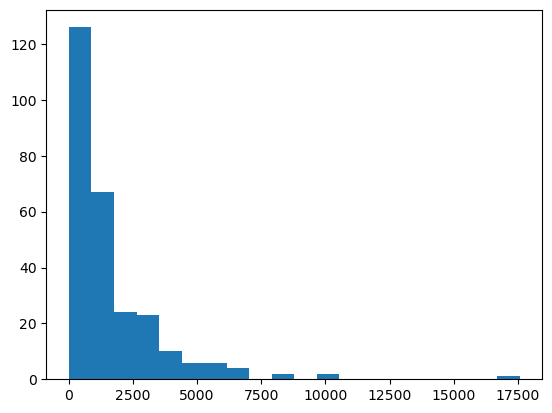

In [57]:
import matplotlib.pyplot as plt

plt.hist(char_counts, bins=20)
plt.show()

In [ ]:
# Idea: Try to retrieve Table of Contents from PDF and attach to context first
# Then, chunk the document, attach as metadata the previous X section titles (retrieve via markdown) + page number?
# Split by chapters? If section too large, split into subsections with table correction?